# Exercise 3.1: Fractional differencing

Exercise based on Chapter 5 of the book *Advances in Financial Machine Learning* by Marcos Lopez de Prado.

There is also an easy to understand introduction to the subject in https://towardsdatascience.com/preserving-memory-in-stationary-time-series-6842f7581800. This guide on  stationarity in Python can be helpful https://www.jdeconomics.com/python-tutorials/stationarity-in-python.

In this exercise we will gain more intuition for fractional differencing, a way of generalizing integer differencing to fractional values. This will allow us to stationarize time series while giving up as little information as possible.

In [6]:
%pip install nolds
%pip install arch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 KB 3.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 KB 8.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 KB 7.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import signal
import seaborn as sns
import nolds
from arch.unitroot import ADF

We will once again work with the dollar bar data we created in the first exercise.

In [8]:
df = pd.read_csv('./data/dollar_bars.csv', parse_dates=['datetime'], index_col='datetime')

If you find the stationarity test is taking too long to run you can also use a subset of the data. Try to use as much of the data as possible if you do this.

In [9]:
#df = df.loc['2013']

--------------------------------------
## Integer differencing

Before moving on to fractional differencing we will start with ordinary integer differencing.

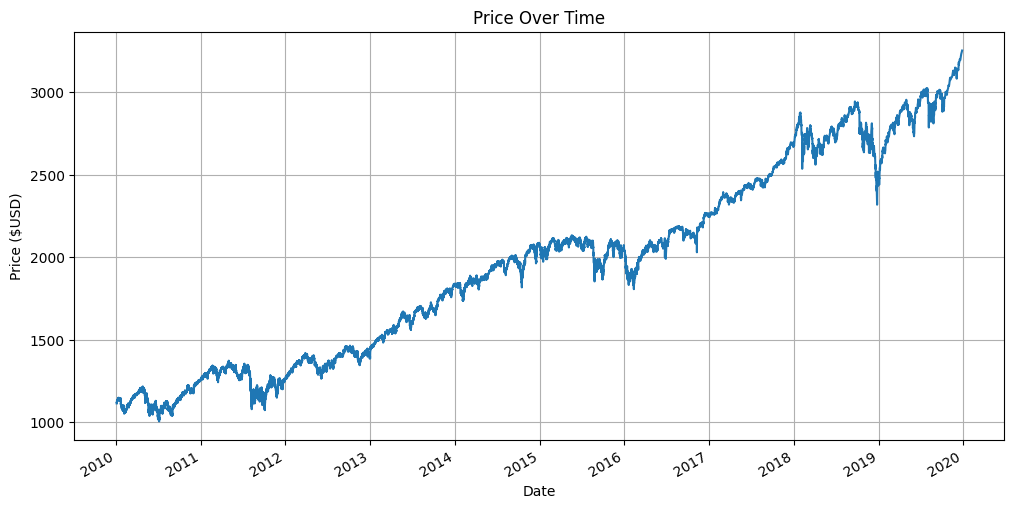

In [10]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the price data
df.plot(y='price', ax=ax, legend=False, grid=True)

# Set title and labels
ax.set_title('Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($USD)')

# Show the plot
plt.show()

While it may visually be quite clear that this time series is not stationary, we can quatify this using the [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null alternative hypothesis of the test is stationarity, meaning a smaller p-value indicates a higher confidence that the time series is stationary. The helper function below performs the test and prints out related statistics.

The test also confirms our visual observation that the time series is not stationary. Let us then perform integer differencing of order 1 and inspect the resulting differenced time series.

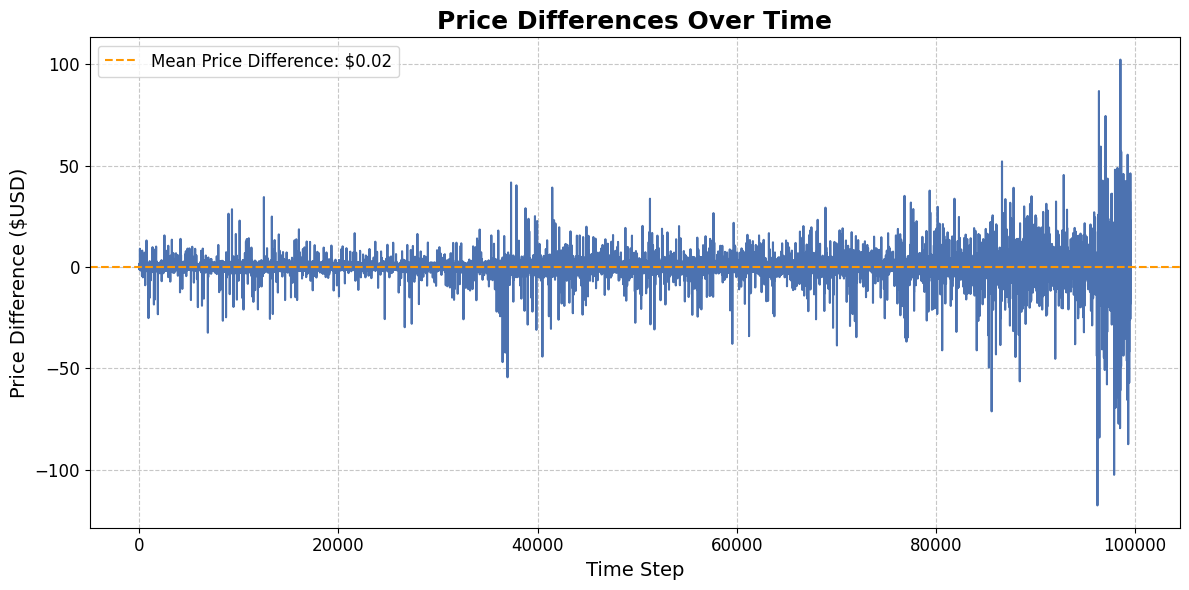

In [12]:
# Calculate the differences in price
diff = np.diff(df['price'])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the differences in price
sns.lineplot(data=diff, ax=ax, linewidth=1.5, color='#4c72b0')

# Customize the plot
ax.set_title('Price Differences Over Time', fontsize=18, fontweight='bold')
ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('Price Difference ($USD)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', labelsize=12)

# Add a horizontal line at the mean price difference
mean_diff = np.mean(diff)
ax.axhline(mean_diff, color='#ff9800', linestyle='--', linewidth=1.5, label=f'Mean Price Difference: ${mean_diff:.2f}')

# Add a legend
ax.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The time series now looks a lot more stationary. The ADF test also confirms this.

In [15]:
ADF(diff)

Test Statistic,-38.195
P-value,0.000
Lags,65


### <u>Task 1</u>

In the code above we managed to stationarize the time series without using any fancy tricks. What are the issues of simply using integer differencing? How might this become apparent when working with the differenced series in downstream tasks? Why is this the case for financial time series, in particular.

**BONUS:** Which types of securities might be especially prone (or robust against) the issues above?

Integer differencing can lose long term information. It is bad for financial data since the price trends can persist for long periods. It is especially bad for low volatility assets which have multi-year price trends, such as bonds and real estate.

-------------------------------
## Fractional differencing

We will now generalize diffrencing for non-integer values by using an arithmetic series of powers of the backshift operator $B$. This version is called the Grunwald-Letnikov fractional differentiation of order $d$ is defined as:

\begin{equation}
D^d f(t) = \lim_{h \to 0} \frac{1}{h^d} \sum_{k=0}^{\left\lfloor \frac{t}{h} \right\rfloor} (-1)^k \binom{d}{k} f(t - kh)
\end{equation}

where:

- $D^d$ denotes the fractional differentiation operator of order \( d \).
- $f(t)$ is the original time series.
- $t$ denotes time.
- $h$ is the step size.
- $\binom{d}{k}$ is the generalized binomial coefficient.


The generalized binomial coefficient is defined as:

\begin{equation}
\binom{d}{k} = \frac{\Gamma(d + 1)}{\Gamma(k + 1) \Gamma(d - k + 1)}
\end{equation}

 This will result in the differenced time series being calculated as a weighted sum of lagged series. The function below calculates these weights using the fixed-window method, where we drop any weights below a certain magnitude.

In [16]:
def get_weights(d, size, threshold=1e-5):
    """ Calculate weights for fractional differentiation of order d. """
    k = np.arange(1, size)
    w_ = np.cumprod(-(d - k + 1) / k)
    w = np.concatenate(([1.0], w_))
    
    """ Here we truncate the weights, when the tail is smaller than the treshold """
    mask = np.abs(w) >= threshold
    last_valid_index = np.max(np.where(mask)[0])
    w = w[:last_valid_index + 1]
    return w[::-1].reshape(-1, 1)  # reverse, match dimensions


We can also plot the weights associated with different lags for diffrencing values of $d$.

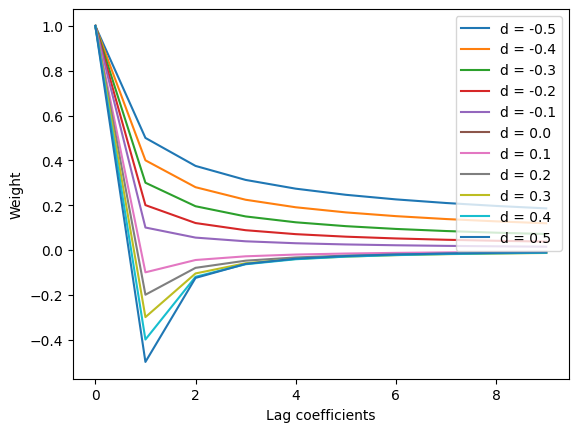

In [17]:
weights = [get_weights(d, 10)[::-1].flatten() for d in np.arange(-0.5, 0.6, 0.1)]

for i, w in enumerate(weights):
    plt.plot(w, label=f'd = {round(-0.5 + i*0.1, 2)}')

plt.xlabel('Lag coefficients')
plt.ylabel('Weight')
plt.legend()
plt.show()

Let us now try out diffrenct fractional values of $d$ and measure stationarity for each one. The function below calculates the differenced time series for a given value of $d$ and a threshold defining the smallest magnitude weights we will utilize. The cell below it calculated the ADF test p-value for diffrent values of $d$.

In [18]:
def fractional_diff(series, d, thresh=1e-5):
    """ Apply fractional differentiation to a time series. """
    length = len(series)
    
    w = get_weights(d, length).flatten()


    diff_values = np.convolve(series.values, w[::-1], mode='full')[:length]
  
   
    # Align the output with the input index
    #return pd.Series(diff_values, index=series.index[(len(weights)-2):]).dropna(inplace=True)
    return pd.Series(diff_values[(len(w)-1):], index=series.index[(len(w)-1):])
    #return diff_values[(len(w)-1):]
    #diff_series.dropna(inplace=True)
    #return diff_series

In [19]:
degree = np.arange(0.1, 1.01, 0.01)
adf_value = [ADF(fractional_diff(df['price'], d), lags=60).pvalue for d in degree]

In [20]:
adf_value

[np.float64(0.9955651595780567),
 np.float64(0.9945452212254624),
 np.float64(0.9930764052801613),
 np.float64(0.9909628047379916),
 np.float64(0.9885999352480215),
 np.float64(0.9852315016305306),
 np.float64(0.9804652400977626),
 np.float64(0.97404483789975),
 np.float64(0.966324029630698),
 np.float64(0.955045856652468),
 np.float64(0.942099809168268),
 np.float64(0.9238444189009979),
 np.float64(0.900602191736489),
 np.float64(0.8727053505068005),
 np.float64(0.8365948032896512),
 np.float64(0.794853620837889),
 np.float64(0.7461521628662899),
 np.float64(0.6804339379603268),
 np.float64(0.6121811348316524),
 np.float64(0.5346429901956145),
 np.float64(0.4516510753862255),
 np.float64(0.3692090631925793),
 np.float64(0.2916888140730154),
 np.float64(0.22188026532108596),
 np.float64(0.160671685236854),
 np.float64(0.11432079273617007),
 np.float64(0.08326849011179632),
 np.float64(0.056795461802720756),
 np.float64(0.03531710979250737),
 np.float64(0.019835731066361433),
 np.float6

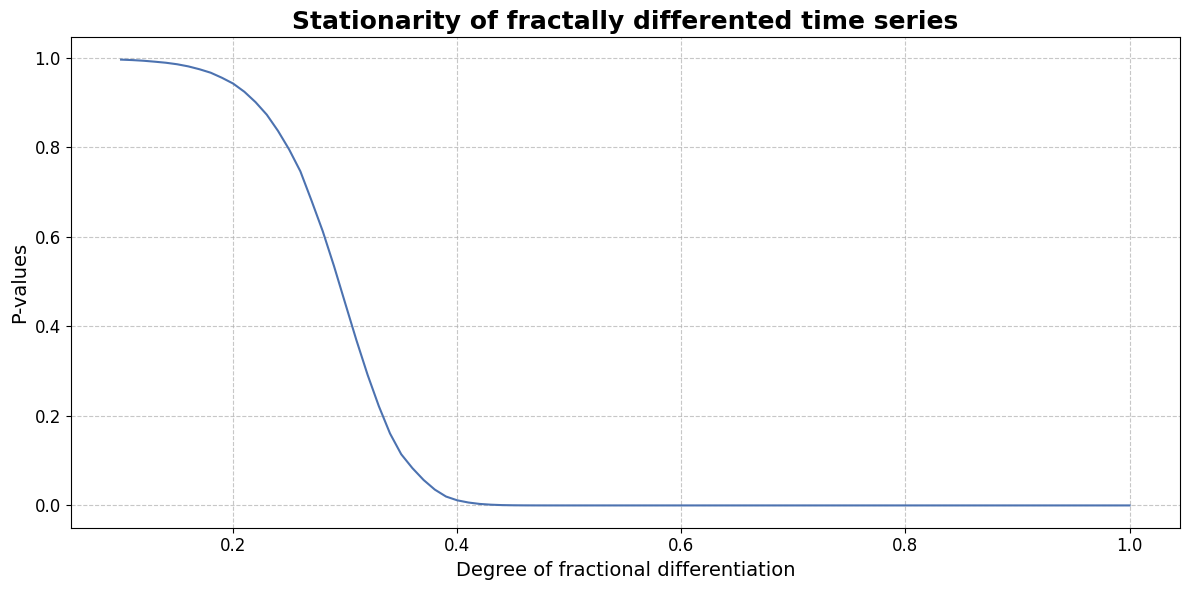

In [21]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the p-values
sns.lineplot(x=degree, y=adf_value, ax=ax, linewidth=1.5, color='#4c72b0')

# Customize the plot
ax.set_title('Stationarity of fractally differented time series', fontsize=18, fontweight='bold')
ax.set_xlabel('Degree of fractional differentiation', fontsize=14)
ax.set_ylabel('P-values', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

--------------------------------------
### <u>Task 2 A</u>

Use the cell below to set a level at which you would be comfortable calling the series stationary (eg 5% or 1%). Then use the plot generated in the following cell to determine the smallest value for $d$ where the chosen confidence is achieved. Use this value of $d$ when moving forward.

In [32]:
# Desired p-value in decimal form (eg 0.01 or 0.05)
p_val = 0.1

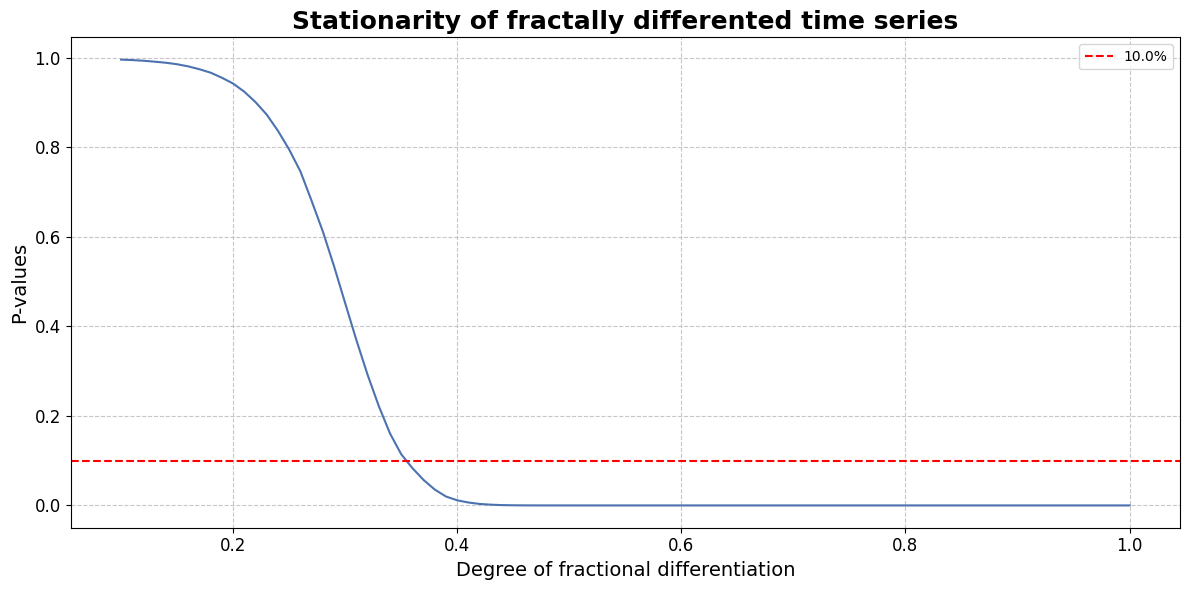

In [33]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the p-values
sns.lineplot(x=degree, y=adf_value, ax=ax, linewidth=1.5, color='#4c72b0')

# Customize the plot
ax.set_title('Stationarity of fractally differented time series', fontsize=18, fontweight='bold')
ax.set_xlabel('Degree of fractional differentiation', fontsize=14)
ax.set_ylabel('P-values', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', labelsize=12)

ax.axhline(p_val, color='red', linestyle='dashed', label=f'{100*p_val}%')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [85]:
# Chosen value of d
chosen_d = 0.4

## <u>Task 2 B</u>

Intuitively, what can you say about the value of $d$ you got. How does this relate to your earlier discussion of the problems associated with integer differencing financial time series?

**BONUS:** Going beyond intuition, how might you quantify "how much better" you value of $d$ is?

The smaller value of d we choose means that we are retenting more information from the original series, while values after 0.4 are basically fully stationary according to the ADF test. The earlier problem we had, is that integer differencing could lose important information from the series, which is why we chose a value of d that balances between stationarity and information loss.

## Further inspection

Finally, having chosen a value of $d$ we can take a closer look at the associated time series. Let's start by plotting it.

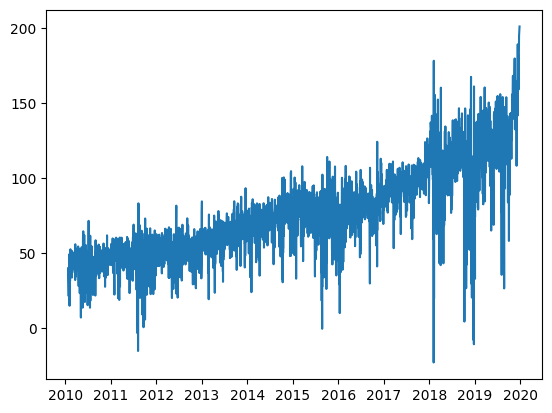

In [86]:
diff = fractional_diff(df['price'], chosen_d)
plt.plot(diff)
plt.show()

We can also take another look at the results of the ADF test.

In [87]:
ADF(diff, lags=60)

Test Statistic,-3.387
P-value,0.011
Lags,60


### <u>Task 3</u>

Inspect the series above visually. How does your visual analysis compare to the one performed using the ADF test? What proprties of the data might explain possible discrepancies? Why might they not be an issue?

Visually we see that the series has retained some memory of the original series in the form of a clear trend line. ADF test gives a p value of 0.011, which means that the series is very close to being stationary. We can visually see that it is not exactly stationary, but it is close, while still retaining the trend. This might not be an issue, since we are interested in predicting future behavior of the price, especially short term trading strategies are more robust to non-stationarity.

### <u>Extra Task 1</u>

We can also just search for the minimal $d$ for which the fractionally differented series is stationary.

In [88]:
def find_fractional(X, precision=0.01, pvalue = 0.05):
    min, max = 0, 1
    while max - min > precision:
        mid = (min + max) / 2
        pv = ADF(fractional_diff(X, mid), lags=60).pvalue
        if pv < pvalue:
            max = mid
        else:
            min = mid
    return max


In [89]:
find_fractional(df['price'], precision=0.01, pvalue = 0.05)

0.375

In [90]:
find_fractional(np.log(df['price']), precision=0.01, pvalue = 0.05)

0.34375

How do these values correspond to your graphical analysis?

How would you use the obtained fractional derivative to predict future behavior of the price?

### <u>Extra Task 2</u>

The *Hurst exponent* is another measure of the long-term memory or predictability in a time series.

A time series with a Hurst exponent value between 0 and 0.5 indicates anti-persistence, meaning that if the series has been increasing recently, it is more likely to decrease in the future, and vice versa. This suggests mean-reverting behavior or a tendency for the series to return to its average.

On the other hand, a Hurst exponent value between 0.5 and 1 indicates persistence, meaning that if the series has been increasing recently, it is more likely to continue increasing in the future, and vice versa. This suggests a trending or trending-like behavior in the series.

In [91]:
hurst_exponent = nolds.hurst_rs(df['price'])

print("Hurst exponent:", hurst_exponent)

Hurst exponent: 0.962124785380158


In [92]:
print("Hurst exponent:", nolds.hurst_rs(np.diff(df['price'])))

Hurst exponent: 0.474349921613452


In [93]:
nolds.hurst_rs(np.diff(np.log(df['price'])))

np.float64(0.4789445830094486)

What happens to the Hurst exponent with differentiation?

The Hurst exponent (H) measures whether a financial time series trends, reverts to its mean, or behaves randomly. 

- **H < 0.5: Mean-Reverting Behavior**

    *Explanation:* The series tends to reverse direction frequently. A price increase is likely followed by a decrease (and vice versa), creating oscillations around a long-term average.

    *Example:* Currency pairs like EUR/CHF often show mean-reverting properties due to central bank interventions or range-bound trading4. Volatility ETFs (e.g., VXX) also frequently revert to historical averages after spikes.

    *Strategy Implication:* Use mean-reversion tactics (e.g., buying dips in a range-bound market or pairs trading).

- **H = 0.5: Random Walk**

    *Explanation:* Prices have no memory—past movements don’t predict future ones. This aligns with the Efficient Market Hypothesis, where all available information is already priced in.

    *Example:* Highly liquid stocks like Apple (AAPL) or major forex pairs (e.g., EUR/USD) in efficient, news-driven markets often exhibit H ≈ 0.5.

    *Strategy Implication:* Avoid trend or mean-reversion strategies; focus on low-latency arbitrage or volatility harvesting.

- **H > 0.5: Trending Behavior**
    
    *Explanation:* The series has persistent momentum. An upward move is likely followed by another upward move (and similarly for downward moves).

    *Example:* Commodities like gold during prolonged bull markets (e.g., 2000–2012) or stock indices like the S&P 500 in multi-year bullish phases.

    *Strategy Implication:* Deploy trend-following strategies (e.g., moving-average crossovers or breakout systems).



| **H Value** | **Market Behavior**   | **Example Assets**         | **Trading Approach**       |
|--------------|-----------------------|----------------------------|----------------------------|
| < 0.5        | Mean-reverting        | EUR/CHF, volatility ETFs   | Range trading, stat arb    |
| 0.5          | Random walk           | AAPL, EUR/USD              | Avoid directional bets     |
| > 0.5        | Trending              | Gold, S&P 500 (bull runs)  | Momentum strategies        |


In practice, H rarely equals exactly 0.5. Traders often treat values between 0.45–0.55 as noise, while extremes (<0.4 or >0.6) signal stronger mean reversion or trends. For instance, Bitcoin’s H often exceeds 0.6 during sustained rallies, reflecting persistent investor sentiment. By matching strategies to H, traders adapt to shifting market dynamics.

The Hurst parameter $\alpha$ is a generalization of the Hurst exponent, with the precise value giving information about the series self-correlations:

- $\alpha <1/2$: anti-correlated

- $\alpha \simeq 1/2$: uncorrelated, white noise

- $\alpha >1/2$: correlated

- $\alpha \simeq 1$: 1/f-noise, pink noise

- $\alpha >1$: non-stationary, unbounded

- $\alpha \simeq 3/2$: Brownian noise, red noise

Because the expected displacement in an uncorrelated random walk of length N grows like ${\sqrt {N}}$, an exponent of ${\tfrac {1}{2}}$ would correspond to uncorrelated white noise. When the exponent is between 0 and 1, the result is fractional Gaussian noise.

Here Detrended Fluctuation Analysis (DFA) is able to take the trend into consideration automatically.

In [94]:
hurst_parameter = nolds.dfa(df['price'])

print("Hurst parameter:", hurst_parameter)

Hurst parameter: 1.4616618498737317


In [95]:
print("Hurst parameter:", nolds.dfa(np.log(df['price'])))

Hurst parameter: 1.4741913671597975


In [96]:
print("Hurst parameter:", nolds.dfa(np.diff(df['price'])))

Hurst parameter: 0.4649251339120426


Do you notice, what happens to the Hurst parameter with differentiation?

What do you think is the connection with the Hurst parameter and the fractional derivative discussed above?

In [97]:

def rolling_hurst(series, window=1000):
    hurst_values = []
    for i in range(len(series) - window + 1):
        window_data = series[i:i+window]
        hurst_values.append(nolds.mfhurst_b(window_data))
    return pd.Series(hurst_values)

# Apply rolling Hurst calculation
rolling_hurst_values = rolling_hurst(df['price'])


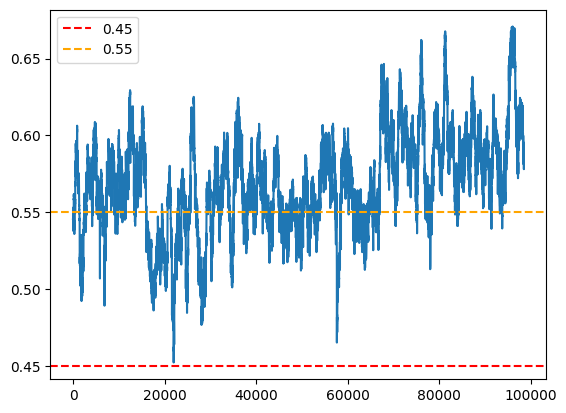

In [98]:
plt.plot(rolling_hurst_values)
plt.axhline(0.45, color='red', linestyle='dashed', label=f'0.45')
plt.axhline(0.55, color='orange', linestyle='dashed', label=f'0.55')
plt.legend()
plt.show()